# Figures

In [1]:
import sys

sys.path.append("/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm")

## Setup

In [2]:
from grokking_llm.utils import (
    DeploymentCfg,
    TrainingCfg,
    get_p_smi_containers,
    get_pointwise_container,
    get_pointwise_layerwise_container,
)
from grokking_llm.measures_dyn import (
    SampleLossMetrics,
    MemoMembershipMetrics,
    MahalanobisMetrics,
    PSmiMetrics,
    PerfMetrics,
    GeneralMetrics,
    LogitGapMetrics,
)
from grokking_llm.training import (
    get_dataset,
    format_dataset,
    add_labels,
    get_random_split,
)

2024-09-20 14:12:20.207 | INFO     | grokking_llm.utils.logs:<module>:20 - Welcome to `grokking_llm` module!
2024-09-20 14:12:20.210 | INFO     | grokking_llm.utils.env_vars:<module>:15 - Found an environment var config at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/env_vars.cfg, exporting its variables.
2024-09-20 14:12:20.213 | DEBUG    | grokking_llm.utils.env_vars:<module>:34 - Exporting env var OMP_NUM_THREADS=2
2024-09-20 14:12:20.216 | DEBUG    | grokking_llm.utils.hf_hub:<module>:32 - Setting env variable HF_HOME=/Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/.cache/huggingface
2024-09-20 14:12:20.217 | INFO     | grokking_llm.utils.hf_hub:<module>:37 - Config internet.offline = false
2024-09-20 14:12:20.220 | DEBUG    | grokking_llm.utils.hf_hub:<module>:49 - Looking for HF token at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/configs/credentials.cfg ...
2024-09-20 14:12:20.225 | INFO     | grokking_llm.utils.hf_hub:<modul

In [3]:
import collections
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KernelDensity

## Loading

In [4]:
setup_names = [
    "arc__mis",
    "ethi_mis",
    "mmlu_mis",
    "mmlu_lla",
    "mmlu_gem",
]
cfg = {
    "arc__mis": TrainingCfg.autoconfig("wd1y"),
    "ethi_mis": TrainingCfg.autoconfig("M-H-"),
    "mmlu_mis": TrainingCfg.autoconfig("Ji5O"),
    "mmlu_lla": TrainingCfg.autoconfig("0K1p"),
    "mmlu_gem": TrainingCfg.autoconfig("dRfd"),
}
dep_cfg = {
    "arc__mis": DeploymentCfg.autoconfig("H5gQ"),
    "ethi_mis": DeploymentCfg.autoconfig("JNey"),
    "mmlu_mis": DeploymentCfg.autoconfig("Z5n7"),
    "mmlu_lla": DeploymentCfg.autoconfig("ZfTT"),
    "mmlu_gem": DeploymentCfg.autoconfig("mD9I"),
}
checkpoints = {
    "arc__mis": [50,100,150,200,250,1000,1750,2500],
    "ethi_mis": [397,794,1191,1588,1985,7940,13895,19850],
    "mmlu_mis": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_lla": [750,1500,2250,3000,3750,15000,26250,37500],
    "mmlu_gem": [750,1500,2250,3000,3750,15000,26250,37500],
}

2024-09-20 14:12:28.440 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: wd1y is the prefix of confi_id wd1yKu7ifTBhJncAHIe3vA in `paths.individual_outputs`, building from it.
2024-09-20 14:12:28.444 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-20 14:12:28.445 | WARNING  | grokking_llm.utils.training_cfg:__init__:735 - You selected `cuda` accelerator, but it is not available. CPU will be used instead.
2024-09-20 14:12:28.451 | INFO     | grokking_llm.utils.training_cfg:autoconfig:383 - Autoconfig `name`: M-H- is the prefix of confi_id M-H-RqkPbMpWRGgOcg-PRA in `paths.individual_outputs`, building from it.
2024-09-20 14:12:28.454 | WARNING  | grokking_llm.utils.training_cfg:__init__:729 - Your configuration is not compatible with the following device: cuda. This is likely to cause errors in yoru pipeline.
2024-09-20

In [5]:
checkpoint_to_epoch = collections.defaultdict(dict)
for setup in setup_names:
    for idx_chk, chk in enumerate(checkpoints[setup]):
        checkpoint_to_epoch[setup][chk] = {
            0: 0.2,
            1: 0.4,
            2: 0.6,
            3: 0.8,
            4: 1.0,
            5: 4.0,
            6: 7.0,
            7: 10.0,
        }[idx_chk]

for setup in setup_names:
    checkpoint_to_epoch[setup][0] = 0

In [6]:
global_idx = {}
for setup in setup_names:
    train_ds = get_dataset(cfg[setup], split="train")
    train_ds = format_dataset(train_ds, cfg[setup])
    train_ds = add_labels(train_ds, cfg[setup], split="train")
    train_ds = get_random_split(train_ds, cfg[setup])
    global_idx[setup] = train_ds["global_index"]

for setup in setup_names:
    print(f"[{setup}] {len(global_idx[setup])} elements")

2024-09-20 14:12:33.203 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:12:33.205 | INFO     | grokking_llm.training.datasets:format_dataset:174 - Formatting dataset ai2_arc
2024-09-20 14:12:33.206 | DEBUG    | grokking_llm.training.datasets:format_dataset:175 - Using seed=0 and force_template=False for formatting.
Map: 100%|██████████| 2000/2000 [00:00<00:00, 5141.24 examples/s]
2024-09-20 14:12:33.604 | INFO     | grokking_llm.training.datasets:add_labels:233 - Adding labels to dataset ai2_arc
2024-09-20 14:12:33.605 | DEBUG    | grokking_llm.training.datasets:add_labels:234 - Using proportion label_noise=0.03334 with seed=0
Map: 100%|██████████| 2000/2000 [00:00<00:00, 6928.63 examples/s]
2024-09-20 14:12:33.908 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:12:33.909 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using spl

[arc__mis] 1000 elements
[ethi_mis] 7940 elements
[mmlu_mis] 15000 elements
[mmlu_lla] 15000 elements
[mmlu_gem] 15000 elements


## Containers

In [7]:
def sanityze(memo_per_chk_per_idx):

    num_changed = 0

    for chk in memo_per_chk_per_idx:
        for idx in memo_per_chk_per_idx[chk]:
            old_val = memo_per_chk_per_idx[chk][idx]
            memo_per_chk_per_idx[chk][idx] = max(-100.0, memo_per_chk_per_idx[chk][idx])
            memo_per_chk_per_idx[chk][idx] = min(100.0, memo_per_chk_per_idx[chk][idx])
            
            if old_val != memo_per_chk_per_idx[chk][idx]:
                num_changed += 1

    print(f"Num item changed: {num_changed}")

In [8]:
memo_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    memo = MemoMembershipMetrics(cfg[setup], dep_cfg[setup])
    memo_df = memo.load_metrics_df()
    memo_per_setup_per_chk_per_idx[setup] = get_pointwise_container(memo_df, memo.column_offset)
    sanityze(memo_per_setup_per_chk_per_idx[setup])

2024-09-20 14:13:31.726 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__init__:48 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 14:13:34.718 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:13:34.727 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:13:34.729 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:13:34.737 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_H5gQZhfMsLE5_NTX9hR7TA` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:13:34.743 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/indi

Num item changed: 145


2024-09-20 14:13:37.025 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset hendrycks/ethics split train
2024-09-20 14:13:37.035 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset hendrycks/ethics
2024-09-20 14:13:37.037 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=7940
2024-09-20 14:13:37.077 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_JNeyT5OUP3GFtJ_QNojppg` on config M-H-RqkPbMpWRGgOcg-PRA
2024-09-20 14:13:37.082 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/M-H-RqkPbMpWRGgOcg-PRA/metrics/memo_on_shadow_JNeyT5OUP3GFtJ_QNojppg.csv
2024-09-20 14:13:37.083 | DEBUG    | grokking_llm.measures_dyn.memo_membership_

Num item changed: 5314


2024-09-20 14:13:43.985 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 14:13:43.996 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 14:13:43.997 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 14:13:44.062 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_Z5n7bEDGK4JRT4HyLKSzrw` on config Ji5OIUTJGuYCYhAzj6KtZQ
2024-09-20 14:13:44.068 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/Ji5OIUTJGuYCYhAzj6KtZQ/metrics/memo_on_shadow_Z5n7bEDGK4JRT4HyLKSzrw.csv
2024-09-20 14:13:44.069 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 4584


2024-09-20 14:13:53.237 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 14:13:53.247 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 14:13:53.248 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 14:13:53.310 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_ZfTT7SCYBAzBtjT3_sy3wg` on config 0K1pZkoAv45RZXOIJl9kFw
2024-09-20 14:13:53.313 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/0K1pZkoAv45RZXOIJl9kFw/metrics/memo_on_shadow_ZfTT7SCYBAzBtjT3_sy3wg.csv
2024-09-20 14:13:53.314 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 193


2024-09-20 14:14:02.346 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset cais/mmlu split train
2024-09-20 14:14:02.355 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset cais/mmlu
2024-09-20 14:14:02.356 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=15000
2024-09-20 14:14:02.424 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `memo_on_shadow_mD9ImObzoCshT5dpStKiMA` on config dRfdcYPXxygGJ2kuZfsYew
2024-09-20 14:14:02.428 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/dRfdcYPXxygGJ2kuZfsYew/metrics/memo_on_shadow_mD9ImObzoCshT5dpStKiMA.csv
2024-09-20 14:14:02.431 | DEBUG    | grokking_llm.measures_dyn.memo_membership_metrics:__ini

Num item changed: 71


In [9]:
p_smi_per_setup_per_chk_per_layer_per_idx = {}
for setup in setup_names:
    p_smi = PSmiMetrics(cfg[setup])
    p_smi_df = p_smi.load_metrics_df(authorized_checkpoints=[0] + checkpoints[setup][0:5])
    p_smi_per_setup_per_chk_per_layer_per_idx[setup] = get_p_smi_containers(p_smi_df)[0]

2024-09-20 14:14:08.093 | INFO     | grokking_llm.measures_dyn.p_smi_metrics:__init__:37 - Initializing a PSmiMetrics with 2000 estimators, and full_dataset=False.
2024-09-20 14:14:08.095 | DEBUG    | grokking_llm.measures_dyn.p_smi_metrics:__init__:43 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 14:14:11.236 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:14:11.243 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:14:11.244 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:14:11.251 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `p_smi_metrics` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:14:11.255 | DEBUG    | grokking_llm.measures_dyn.dynamic_

In [10]:
loss_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    loss = SampleLossMetrics(cfg[setup])
    loss_df = loss.load_metrics_df(authorized_checkpoints=[0] + checkpoints[setup][0:5])
    loss_per_setup_per_chk_per_idx[setup] = get_pointwise_container(loss_df, loss.column_offset)

2024-09-20 14:32:10.036 | DEBUG    | grokking_llm.measures_dyn.sample_loss_metrics:__init__:23 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 14:32:13.850 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:32:13.858 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:32:13.859 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:32:13.865 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `sample_loss` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:32:13.871 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/wd1yKu7ifTBhJncAHIe3vA/

In [11]:
mahd_per_setup_per_chk_per_layer_per_idx = {}
for setup in setup_names:
    mahd = MahalanobisMetrics(cfg[setup])
    mahd_df = mahd.load_metrics_df(authorized_checkpoints=[0] + checkpoints[setup][0:5])
    mahd_per_setup_per_chk_per_layer_per_idx[setup] = get_pointwise_layerwise_container(mahd_df)

2024-09-20 14:32:34.393 | INFO     | grokking_llm.measures_dyn.mahalanobis_metrics:__init__:29 - Initializing a MahalanobisMetrics estimator.
2024-09-20 14:32:34.399 | DEBUG    | grokking_llm.measures_dyn.mahalanobis_metrics:__init__:32 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 14:32:37.398 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:32:37.406 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:32:37.409 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:32:37.418 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `mahalanobis_metrics` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:32:37.425 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_gr

In [12]:
logg_per_setup_per_chk_per_idx = {}
for setup in setup_names:
    logg = LogitGapMetrics(cfg[setup])
    logg_df = logg.load_metrics_df(authorized_checkpoints=[0] + checkpoints[setup][0:5])
    logg_per_setup_per_chk_per_idx[setup] = get_pointwise_container(logg_df, column_offset=logg.column_offset)

2024-09-20 14:38:21.724 | DEBUG    | grokking_llm.measures_dyn.logit_gap_metrics:__init__:32 - Loading dataset to retrieve global IDX of the elements of the random split.
2024-09-20 14:38:24.762 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:38:24.770 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:38:24.772 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:38:24.781 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `logits_gap` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:38:24.788 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/wd1yKu7ifTBhJncAHIe3vA/met

In [13]:
perf_df_per_setup = {}
for setup in setup_names:
    general_df = GeneralMetrics(cfg[setup]).load_metrics_df()
    perf = PerfMetrics(cfg[setup])
    perf_df_per_setup[setup] = perf.load_metrics_df().merge(general_df[["checkpoint", "epoch"]], on="checkpoint", how="left")

2024-09-20 14:38:48.041 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `general` on config wd1yKu7ifTBhJncAHIe3vA
2024-09-20 14:38:48.046 | DEBUG    | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:76 - Found existing output file at /Users/jeremie/Documents/01-Travail/01-Doctorat/grokking_llm/output/individual/wd1yKu7ifTBhJncAHIe3vA/metrics/general.csv
2024-09-20 14:38:51.044 | INFO     | grokking_llm.training.datasets:get_dataset:144 - Loading dataset ai2_arc split train
2024-09-20 14:38:51.056 | INFO     | grokking_llm.training.datasets:get_random_split:277 - Getting random split 0 from dataset ai2_arc
2024-09-20 14:38:51.059 | DEBUG    | grokking_llm.training.datasets:get_random_split:278 - Using split_prop=0.5, resulting in a split of length=1000
2024-09-20 14:38:51.067 | INFO     | grokking_llm.measures_dyn.dynamic_metrics_group:__init__:62 - Creating a dynamic metric object to measure `perf_metrics`

## Preliminary: checking best layer for mahalanobis

NB: the best layer for PSMI is checked in the "02_appendix_figures.ipynb" notebook.

In [14]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

In [15]:
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

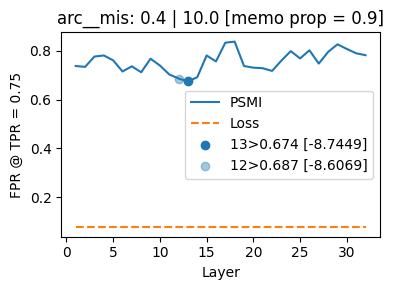

In [16]:
n_rows = 1
n_cols = 1
setup = "arc__mis"

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

predictors = {
    layer: (
        [mahd_per_setup_per_chk_per_layer_per_idx[setup][100][layer][idx] for idx in global_idx[setup]],
        False,
    )
    for layer in cfg[setup].all_layers
} | {
    "LOSS       ": (
        [loss_per_setup_per_chk_per_idx[setup][100][idx] for idx in global_idx[setup]],
        False,
    ),
}

# Iterating over predictors
fpr_at_layer = {}
pred_thd = {}
fpr_loss = None
for pred_name, (pred, reversed) in predictors.items():
    memo = [memo_per_setup_per_chk_per_idx[setup][2500][idx] for idx in global_idx[setup]]
    if reversed:
        pred = [-1 * item for item in pred]
    
    # Sorting 
    sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
    nan_index = set([
        idx for idx in range(len(pred))
        if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
    ])
    memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
    pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

    # Who is memorized ?
    memo_thd = np.quantile(memo, q=MEMO_PROP)
    is_memorized = [item >= memo_thd for item in memo]

    # Prec-rec curve
    fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

    # FPR @ 0.8 TPR
    for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
        if final_tpr > TPR_OBJ:
            break

    if type(pred_name) == int:
        fpr_at_layer[pred_name] = final_fpr
        pred_thd[pred_name] = -1 * final_thd
    elif "LOSS" in pred_name:
        fpr_loss = final_fpr
    else:
        raise ValueError(f"Unknow pred name: {pred_name}")

layers = sorted(fpr_at_layer.keys())
values = [fpr_at_layer[l] for l in layers]
thresholds = [pred_thd[l] for l in layers]
sorting_idx = sorted(range(len(values)), key=lambda k: values[k])
min_fpr, next_min_fpr = values[sorting_idx[0]], values[sorting_idx[1]]
min_thd, next_min_thd = thresholds[sorting_idx[0]], thresholds[sorting_idx[1]]
min_layer, next_min_layer = layers[sorting_idx[0]], layers[sorting_idx[1]]

# Plotting

ax.plot(layers, values, label=f"PSMI")
ax.plot(layers, [fpr_loss for _ in layers], label=f"Loss", linestyle="--")

# Plot details
ax.set_title(f"{setup}: {checkpoint_to_epoch[setup][100]} | {checkpoint_to_epoch[setup][2500]} [memo prop = {MEMO_PROP}]")
ax.set_xlabel("Layer")
ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")

# Scatter
ax.scatter(min_layer, min_fpr, color=COLORS[0], label=f"{min_layer}>{min_fpr:.3f} [{min_thd:.4f}]")
ax.scatter(next_min_layer, next_min_fpr, color=COLORS[0], alpha= 0.4, label=f"{next_min_layer}>{next_min_fpr:.3f} [{next_min_thd:.4f}]")


ax.legend()

fig.tight_layout()


## Figure 1: TPR/FPR curve for ARC Mistral

In [17]:
TPR_OBJ = 0.75
MEMO_PROP = 0.90
INDEX_MEMO = -1

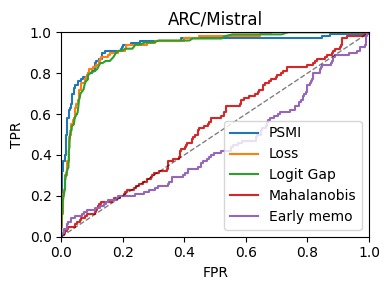

In [18]:
n_rows = 1
n_cols = 1
setup = "arc__mis"

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

chk_pred = 100
predictors = {
    f"PSMI": (
        [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][29][idx] for idx in global_idx[setup]],
        True,
    ),
    "Loss": (
        [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
        False,
    ),
    f"Logit Gap": (
        [logg_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
        True,
    ),
    f"Mahalanobis": (
        [mahd_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][13][idx] for idx in global_idx[setup]],
        False,
    ),
    f"Early memo": (
        [memo_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
        False,
    ),
}

# Iterating over predictors
for pred_name, (pred, reversed) in predictors.items():
    memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
    if reversed:
        pred = [-1 * item for item in pred]
    
    # Sorting 
    sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
    nan_index = set([
        idx for idx in range(len(pred))
        if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
    ])
    memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
    pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

    # Who is memorized ?
    memo_thd = np.quantile(memo, q=MEMO_PROP)
    is_memorized = [item >= memo_thd for item in memo]

    # Prec-rec curve
    fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

    # FPR @ 0.8 TPR
    for final_fpr, final_tpr in zip(fpr, tpr):
        if final_tpr > TPR_OBJ:
            break

    label = f"{pred_name}"
    ax.plot(fpr, tpr, label=label)

# Plot details
ax.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--', alpha=.5)
# ax.plot([0, 1], [TPR_OBJ, TPR_OBJ], color='navy', lw=1, linestyle='--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

ax.set_title(f"ARC/Mistral")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")


ax.legend()
fig.tight_layout()

fig.savefig("perf_tpr_fpr.pdf")



## Perf: measure timeline

In [19]:
MEMO_PROP = 0.90
INDEX_MEMO = -1

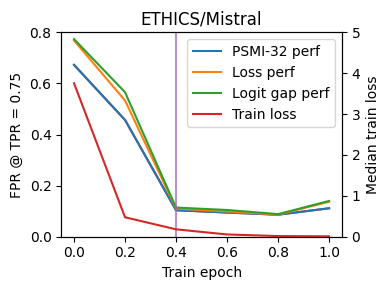

In [20]:
n_rows = 1
n_cols = 1
setup = "ethi_mis"

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

chk_memo = 19850

fpr_at_per_pred = collections.defaultdict(list)
chk_to_pred = [0] + checkpoints[setup][0:5]
pred_median_per_chk = collections.defaultdict(list)
for chk_pred in chk_to_pred:

    # Predictors
    predictors = {
        f"PSMI-{32}  ": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][32][idx] for idx in global_idx[setup]],
            True,
        ),
        "LOSS       ": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
        "Logit Gap       ": (
            [logg_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            True,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Median
        pred_median_per_chk[pred_name].append(
            np.median(pred) if not reversed else -1 * np.median(pred)
        )

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # FPR @ 0.8 TPR
        for final_fpr, final_tpr in zip(fpr, tpr):
            if final_tpr > TPR_OBJ:
                break

        fpr_at_per_pred[pred_name].append(final_fpr)

# When did the median loss cross

# The real PSMI and loss perf
ax.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], fpr_at_per_pred[f"PSMI-{32}  "], label=f"PSMI-32 perf", color=COLORS[0])
ax.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], fpr_at_per_pred[f"LOSS       "], label=f"Loss perf", color=COLORS[1])
ax.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], fpr_at_per_pred[f"Logit Gap       "], label=f"Logit gap perf", color=COLORS[2])
# A fake PSMI under the other for the legend of the loss
ax.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], fpr_at_per_pred[f"PSMI-{32}  "], label=f"Train loss", color=COLORS[3], zorder=-1)
# The real loss
ax_loss = ax.twinx()
ax_loss.plot([checkpoint_to_epoch[setup][chk] for chk in chk_to_pred], pred_median_per_chk["LOSS       "], color = COLORS[3])
# The vline
ax.axvline(0.4, color=COLORS[4], linestyle="-", alpha=.7)

# Plot details
ax.set_title(f"ETHICS/Mistral")
ax.set_xlabel("Train epoch")
ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
ax.set_ylim(0, 0.8)
ax_loss.set_ylim(0, 5)
ax_loss.set_ylabel("Median train loss")
ax.legend()

fig.tight_layout()

fig.savefig("perf_measure_timeline.pdf")

## Perfs: compare predictors

#### Preliminary: checking when did loss decreased by at least 95\%

In [21]:
med_losses_per_setup = collections.defaultdict(list)
SETUP_TO_PRED_IDX = {}
med_loss_thd = 1 - 0.95

# Filling median values
for setup in setup_names:
    for chk in [0] + checkpoints[setup][:5]:
        losses = [loss_per_setup_per_chk_per_idx[setup][chk][idx] for idx in global_idx[setup]]
        med_losses_per_setup[setup].append(np.median(losses))

# Finding checkpoint
for setup in setup_names:
    for idx in range(1, 6):
        if med_losses_per_setup[setup][idx] < med_loss_thd * med_losses_per_setup[setup][0]:
            SETUP_TO_PRED_IDX[setup] = idx - 1
            break

    print(f"{setup}: {idx} [thd { med_loss_thd * med_losses_per_setup[setup][0]:.4f}] -> {med_losses_per_setup[setup]}")

print(SETUP_TO_PRED_IDX)


arc__mis: 2 [thd 0.2530] -> [5.060225009918213, 0.3132113218307495, 0.11674169450998301, 0.0215810909867286, 0.023197457194328253, 0.00324188126251095]
ethi_mis: 2 [thd 0.1877] -> [3.753878593444824, 0.4751560688018799, 0.1808940917253494, 0.055170577019453, 0.0161793949082493, 0.0098143424838781]
mmlu_mis: 1 [thd 0.2660] -> [5.320712566375732, 0.0461935512721538, 0.00965839298442, 0.00278781319502735, 0.0049524258356541, 0.0063392033334821]
mmlu_lla: 2 [thd 0.3000] -> [5.999611139297485, 0.42379190027713776, 0.0819721259176731, 0.0431522317230701, 0.03335151262581345, 0.05773136764764785]
mmlu_gem: 1 [thd 0.2576] -> [5.15212607383728, 0.0317739006131887, 0.0071915455628186, 0.0037473472766578, 0.00375067256391045, 0.00743372971192]
{'arc__mis': 1, 'ethi_mis': 1, 'mmlu_mis': 0, 'mmlu_lla': 1, 'mmlu_gem': 0}


#### Figure 3

In [22]:
DEFAULT_LAYERS = {
    "arc__mis": (29,20),
    "ethi_mis": (32,30),
    "mmlu_mis": (23,25),
    "mmlu_lla": (20,19),
    "mmlu_gem": (21,26),
}

In [23]:
PRETTY_SETUP = {
    "arc__mis": "ARC/Mistral",
    "ethi_mis": "ETHICS/Mistral",
    "mmlu_mis": "MMLU/Mistral",
    "mmlu_lla": "MMLU/Llama",
    "mmlu_gem": "MMLU/Gemma",
}

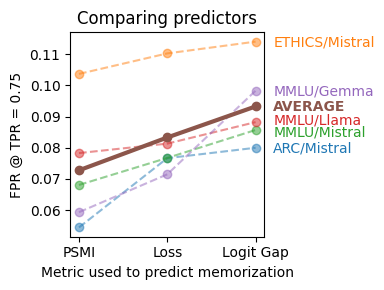

In [24]:
n_rows = 1
n_cols = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

perf_per_setup = collections.defaultdict(list)

# Iterating over setups
for setup in setup_names:

    chk_pred = checkpoints[setup][SETUP_TO_PRED_IDX[setup]]
    chk_memo = checkpoints[setup][-1]

    # Predictors
    predictors = {
        f"PSMI": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][DEFAULT_LAYERS[setup][0]][idx] for idx in global_idx[setup]],
            True,
        ),
        f"Loss": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
        f"Logit Gap": (
            [logg_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            True,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # FPR @ 0.8 TPR
        for final_fpr, final_tpr in zip(fpr, tpr):
            if final_tpr > TPR_OBJ:
                break

        # Saving
        perf_per_setup[setup].append(final_fpr)

val_per_pred = collections.defaultdict(list)
# Mean per predictor
for setup in setup_names:
    for idx_pred, pred_name in enumerate(predictors):
        val_per_pred[pred_name].append(perf_per_setup[setup][idx_pred])

mean_per_pred = {}
for pred_name in val_per_pred:
    mean_per_pred[pred_name] = np.mean(val_per_pred[pred_name])

# Plotting
offset = [0, 0, -0.0007, 0.0007, 0, 0, 0]
for idx_setup, (setup, perfs) in enumerate(perf_per_setup.items()):
    ax.plot(range(len(predictors)), perfs, 'o--', label=PRETTY_SETUP[setup], alpha=.5)
    ax.text(2.2, perfs[-1] - 0.0015 + offset[idx_setup],PRETTY_SETUP[setup], color = COLORS[idx_setup])
ax.plot(range(len(predictors)), list(mean_per_pred.values()), 'o-', label="AVERAGE", alpha=1, linewidth=3, color=COLORS[len(setup_names)])
ax.text(2.2, list(mean_per_pred.values())[-1] - 0.0015 + offset[len(setup_names)], "AVERAGE", color = COLORS[len(setup_names)], fontweight="heavy")

ax.set_xticks(range(len(predictors)), list(predictors.keys()))
ax.set_xlabel(f"Metric used to predict memorization")
ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
ax.set_title(f"Comparing predictors")
# ax.legend()
fig.tight_layout()

fig.savefig("perf_compare_preds.pdf")


In [25]:
mean_per_pred

{'PSMI': 0.07276850452467581,
 'Loss': 0.08329874055415616,
 'Logit Gap': 0.0932544080604534}

## Teaser

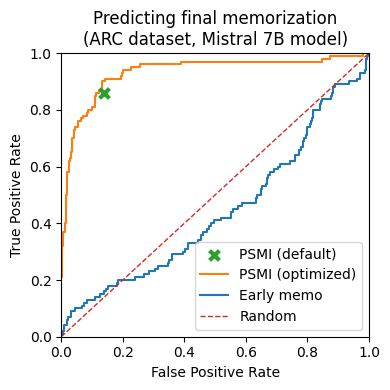

In [26]:
local_colors = COLORS[2], COLORS[1], COLORS[0], COLORS[3]

n_rows = 1
n_cols = 1
setup = "arc__mis"

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))

chk_pred = 100
predictors = {
    f"PSMI (default)": (
        [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][32][idx] for idx in global_idx[setup]],
        True,
    ),
    f"PSMI (optimized)": (
        [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][29][idx] for idx in global_idx[setup]],
        True,
    ),
    f"Early memo": (
        [memo_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
        False,
    ),
}

# Iterating over predictors
for idx_pred, (pred_name, (pred, reversed)) in enumerate(predictors.items()):
    memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
    if reversed:
        pred = [-1 * item for item in pred]
    
    # Sorting 
    sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
    nan_index = set([
        idx for idx in range(len(pred))
        if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
    ])
    memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
    pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

    # Who is memorized ?
    memo_thd = np.quantile(memo, q=MEMO_PROP)
    is_memorized = [item >= memo_thd for item in memo]

    # Prec-rec curve
    fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

    # FPR @ 0.8 TPR
    for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
        if final_thd < 0:
            break
    
    if "default" in pred_name:
        ax.scatter(final_fpr, final_tpr, marker="x", label=pred_name, s=50, linewidths=3, zorder=10, color=local_colors[idx_pred])
    else:
        ax.plot(fpr, tpr, label=pred_name, color=local_colors[idx_pred])

# Plot details
ax.plot([0, 1], [0, 1], lw=1, linestyle='--', label="Random", color=local_colors[idx_pred + 1])
# ax.plot([0, 1], [TPR_OBJ, TPR_OBJ], lw=1, linestyle='--', label="TPR objective", color="navy")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])

ax.set_title(f"Predicting final memorization\n(ARC dataset, Mistral 7B model)")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")


ax.legend()
fig.tight_layout()

fig.savefig("teaser_1.pdf")


## Ablation: Off the shell parameters

ethi_mis 0.4 0.16974531206269242 0.8513853904282116
arc__mis 0.4 0.1388888888888889 0.86
mmlu_mis 0.2 0.1502962962962963 0.914
mmlu_lla 0.4 0.18022222222222223 0.9173333333333333
mmlu_gem 0.2 0.12451851851851851 0.8906666666666667


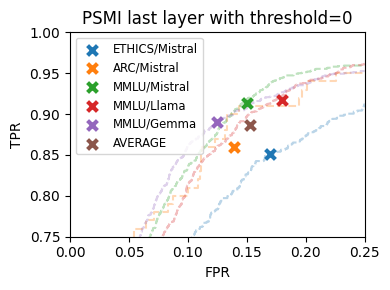

In [39]:
n_rows = 1
n_cols = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# Average
fpr_for_average = []
tpr_for_average = []

# Iterating over setups
for idx_setup, setup in enumerate(["ethi_mis", "arc__mis", "mmlu_mis", "mmlu_lla", "mmlu_gem"]):

    chk_pred = checkpoints[setup][SETUP_TO_PRED_IDX[setup]]
    chk_memo = checkpoints[setup][-1]

    # Predictors
    predictors = {
        f"PSMI": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][DEFAULT_LAYERS[setup][0]][idx] for idx in global_idx[setup]],
            True,
        ),
        f"PSMI-last": (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][32 if "gem" not in setup else 27][idx] for idx in global_idx[setup]],
            True,
        ),
    }

    # Iterating over predictors
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # Easy predictor
        for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
            if final_thd < 0:
                break
        if "last" not in pred_name:
            ax.plot(fpr, tpr, color=COLORS[idx_setup], alpha=.3, linestyle="--")
        else:
            fpr_for_average.append(final_fpr)
            tpr_for_average.append(final_tpr)
            ax.scatter(final_fpr, final_tpr, color=COLORS[idx_setup], label=PRETTY_SETUP[setup], marker="x", s=50, linewidths=3, zorder=10)
            print(setup, checkpoint_to_epoch[setup][chk_pred], final_fpr, final_tpr)

# Scatter the average
ax.scatter(np.mean(fpr_for_average), np.mean(tpr_for_average), color=COLORS[5], label="AVERAGE", marker="x", s=50, linewidths=3, zorder=10)

ax.legend(ncol=1, loc="upper left", fontsize="small")
ax.set_xlim(0, 0.25)
ax.set_ylim(0.75, 1.0)
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("PSMI last layer with threshold=0")

# Figure
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25))
fig.tight_layout()
fig.savefig("ablation_off_the_sheld.pdf")

In [40]:
np.mean(fpr_for_average), np.mean(tpr_for_average)

(0.15273424759772367, 0.8866770780856423)

## Ablation: layers

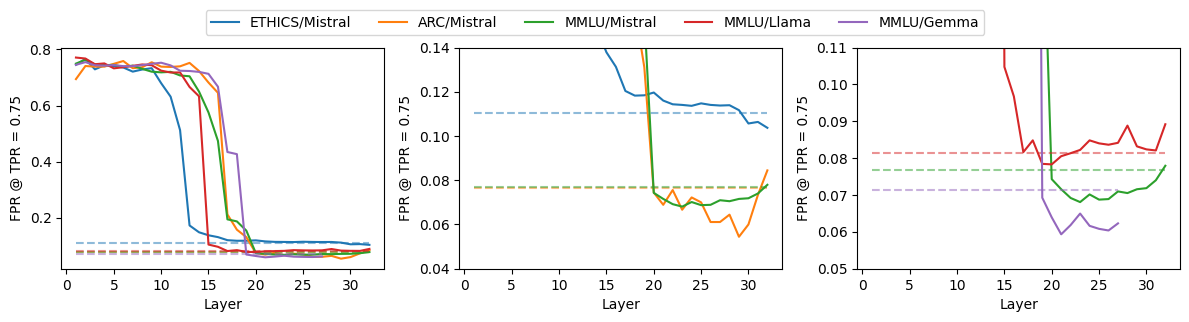

In [29]:
n_rows = 1
n_cols = 3

fig, (ax_all, ax_mist, ax_mmlu) = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

BEST_PER_SETUP = {}
for idx_setup, setup in enumerate(["ethi_mis", "arc__mis", "mmlu_mis", "mmlu_lla", "mmlu_gem"]):

    # Checkpoints
    chk_pred = checkpoints[setup][SETUP_TO_PRED_IDX[setup]]
    chk_memo = checkpoints[setup][-1]

    # Predictors
    predictors = {
        layer: (
            [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][layer][idx] for idx in global_idx[setup]],
            True,
        )
        for layer in cfg[setup].all_layers
    } | {
        "LOSS": (
            [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
            False,
        ),
    }

    # Iterating over predictors
    fpr_at_layer = {}
    pred_thd = {}
    fpr_loss = None
    for pred_name, (pred, reversed) in predictors.items():
        memo = [memo_per_setup_per_chk_per_idx[setup][chk_memo][idx] for idx in global_idx[setup]]
        if reversed:
            pred = [-1 * item for item in pred]
        
        # Sorting 
        sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
        nan_index = set([
            idx for idx in range(len(pred))
            if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
        ])
        memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
        pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

        # Who is memorized ?
        memo_thd = np.quantile(memo, q=MEMO_PROP)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # FPR @ 0.8 TPR
        for final_fpr, final_tpr, final_thd in zip(fpr, tpr, thd):
            if final_tpr > TPR_OBJ:
                break

        if type(pred_name) == int:
            fpr_at_layer[pred_name] = final_fpr
            pred_thd[pred_name] = -1 * final_thd
        elif "LOSS" in pred_name:
            fpr_loss = final_fpr
        else:
            raise ValueError(f"Unknow pred name: {pred_name}")
        
    layers = sorted(fpr_at_layer.keys())
    values = [fpr_at_layer[l] for l in layers]

    # Best ?
    BEST_PER_SETUP[setup] = layers[np.argmin(values)]

    # Plotting - all
    ax_all.plot(layers, values, label=PRETTY_SETUP[setup], color=COLORS[idx_setup])
    ax_all.plot(layers, [fpr_loss for _ in layers], linestyle="--", alpha=.5, color=COLORS[idx_setup])

    # Plotting - mistral
    if "mis" in setup:
        ax_mist.plot(layers, values, color=COLORS[idx_setup])
        ax_mist.plot(layers, [fpr_loss for _ in layers], linestyle="--", alpha=.5, color=COLORS[idx_setup])

    # Plotting - mmlu
    if "mmlu" in setup:
        ax_mmlu.plot(layers, values, color=COLORS[idx_setup])
        ax_mmlu.plot(layers, [fpr_loss for _ in layers], linestyle="--", alpha=.5, color=COLORS[idx_setup])

# Plotting details
ax_all.set_xlabel("Layer")
ax_all.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
ax_mist.set_xlabel("Layer")
ax_mist.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
ax_mmlu.set_xlabel("Layer")
ax_mmlu.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")

ax_mist.set_ylim(0.04, 0.14)
ax_mmlu.set_ylim(0.05, 0.11)

# Fig
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, ncol=5, loc='upper center', bbox_to_anchor=(0.5, 1.08))
fig.tight_layout()
fig.savefig("ablation_layers.pdf", bbox_inches='tight')

In [30]:
BEST_PER_SETUP

{'ethi_mis': 32,
 'arc__mis': 29,
 'mmlu_mis': 23,
 'mmlu_lla': 20,
 'mmlu_gem': 21}

## Ablation: Quantiles

In [31]:
memo_quantiles = np.linspace(0.03, 0.25, 24)
setup = "mmlu_gem"

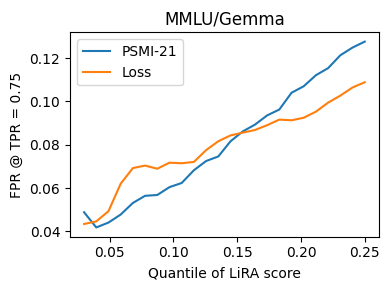

In [32]:
n_rows = 1
n_cols = 1

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# Checkpoints
chk_pred = checkpoints[setup][SETUP_TO_PRED_IDX[setup]]
chk_memo = checkpoints[setup][-1]

# Predictors
best_layer = DEFAULT_LAYERS[setup][0]
predictors = {
    f"PSMI-{best_layer}": (
        [p_smi_per_setup_per_chk_per_layer_per_idx[setup][chk_pred][best_layer][idx] for idx in global_idx[setup]],
        True,
    ),
    "Loss": (
        [loss_per_setup_per_chk_per_idx[setup][chk_pred][idx] for idx in global_idx[setup]],
        False,
    ),
}

# Iterating over predictors
for pred_name, (pred, reversed) in predictors.items():
    memo = [memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][INDEX_MEMO]][idx] for idx in global_idx[setup]]
    if reversed:
        pred = [-1 * item for item in pred]
    
    # Sorting 
    sorting_index = sorted(range(len(pred)), key=lambda k: pred[k])
    nan_index = set([
        idx for idx in range(len(pred))
        if np.isnan(pred[idx]) or np.isnan(memo[idx]) or np.abs(pred[idx]) > 2**63
    ])
    memo = [memo[idx] for idx in sorting_index if idx not in nan_index]
    pred = [pred[idx] for idx in sorting_index if idx not in nan_index]

    # Who is memorized ?
    fpr_at = []
    for q in memo_quantiles:

        memo_thd = np.quantile(memo, q=1-q)
        is_memorized = [item >= memo_thd for item in memo]

        # Prec-rec curve
        fpr, tpr, thd = roc_curve(is_memorized, pred, drop_intermediate=False)

        # FPR @ 0.8 TPR
        for final_fpr, final_tpr in zip(fpr, tpr):
            if final_tpr > TPR_OBJ:
                break

        fpr_at.append(final_fpr)

    # Plotting
    ax.plot(memo_quantiles, fpr_at, label=f"{pred_name}")

# Plotting details
ax.legend()
ax.set_xlabel("Quantile of LiRA score")
ax.set_ylabel(f"FPR @ TPR = {TPR_OBJ}")
ax.set_title("MMLU/Gemma")

# Figure
fig.tight_layout()
fig.savefig("ablation_quantiles.pdf")

## Clean memorization

In [33]:
setup = "mmlu_gem"

23.558022242216932
3.349217291864345


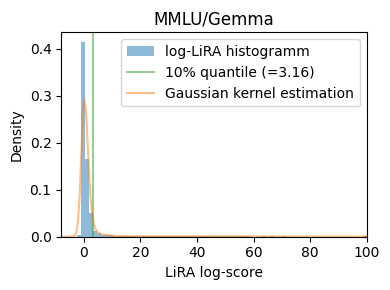

In [34]:
n_rows = 1
n_cols = 1

min_x = -8
max_x = 100
bandwidth = 1
bins = 100

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))

# Memo
memo = np.array([memo_per_setup_per_chk_per_idx[setup][checkpoints[setup][-1]][idx] for idx in global_idx[setup]]).reshape(-1, 1)

# Plot
ax.hist(memo, bins=bins, density=True, alpha=.5, label="log-LiRA histogramm", color=COLORS[0])
quantile = np.quantile(memo, q=.9)
ax.axvline(quantile, linestyle="-", alpha=.5, label=f"10% quantile (={quantile:.2f})", color=COLORS[2])

# Kernel estimation
x_estimation = np.linspace(min_x, max_x, 200).reshape(-1, 1)
kde = KernelDensity(kernel="gaussian", bandwidth=bandwidth).fit(memo)
x_likelihood = np.exp(kde.score_samples(x_estimation))
ax.plot(x_estimation, x_likelihood, label="Gaussian kernel estimation", alpha=.5, color=COLORS[1])

# Print log threshold
print(np.exp(quantile))
print(np.exp(np.quantile(memo, q=.75)))

# Plot details
ax.set_xlabel("LiRA log-score")
ax.set_ylabel("Density")
ax.set_title("MMLU/Gemma")
ax.legend()
ax.set_xlim(min_x, max_x)
fig.tight_layout()
fig.savefig("ablation_memo_hist.pdf")